In [1]:
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

print("Optimizing Windborne's Balloon Location Based on Hurricane Landfall")
print("=" * 60)

## Cell 1: Fetch Windborne Balloon Data

def fetch_balloon_data():
    """
    Fetch current balloon positions from Windborne API
    Each balloon is a list of [X, Y, Z] coordinates
    """
    
    url = "https://a.windbornesystems.com/treasure/00.json"
    
    response = requests.get(url, timeout=10)
    if response.status_code != 200:
        print("❌ No balloon data available")
        return pd.DataFrame()
    
    data = response.json()
    print(f"✅ Successfully fetched data from API")
    
    balloon_records = []
    
    if isinstance(data, list):
        for i, balloon_coords in enumerate(data):
            if isinstance(balloon_coords, list) and len(balloon_coords) >= 3:
                x = float(balloon_coords[0])  # X coordinate (longitude)
                y = float(balloon_coords[1])  # Y coordinate (latitude)
                z = float(balloon_coords[2])  # Z coordinate (altitude)
                
                # Filter out balloons in negative latitudes (Southern Hemisphere)
                if y >= 0:
                    balloon_records.append({
                        'x': x,
                        'y': y,
                        'z': z
                    })
    else:
        print("❌ No balloon data available")
        return pd.DataFrame()
    
    if not balloon_records:
        print("❌ No balloon data available in target region")
        return pd.DataFrame()
    
    print(f"📊 Processed {len(balloon_records)} balloon positions (Northern Hemisphere only)")
    return pd.DataFrame(balloon_records)

# Fetch balloon data
balloon_df = fetch_balloon_data()

if not balloon_df.empty:
    print(f"\n✅ Balloon Data Summary:")
    print(f"Number of balloons: {len(balloon_df)}")
    print(f"Longitude range: {balloon_df['x'].min():.2f} to {balloon_df['x'].max():.2f}")
    print(f"Latitude range: {balloon_df['y'].min():.2f} to {balloon_df['y'].max():.2f}")
    print(f"Altitude range: {balloon_df['z'].min():.0f} to {balloon_df['z'].max():.0f}")
    print("\n🔍 Sample balloon data:")
    print(balloon_df.head())


Optimizing Windborne's Balloon Location Based on Hurricane Landfall
✅ Successfully fetched data from API
📊 Processed 511 balloon positions (Northern Hemisphere only)

✅ Balloon Data Summary:
Number of balloons: 511
Longitude range: -85.74 to 83.15
Latitude range: 0.00 to 178.89
Altitude range: 0 to 22

🔍 Sample balloon data:
           x           y          z
0  70.789291   37.272190   2.703648
1  -8.862796  142.935869  12.292538
2 -16.140942   74.202958   9.099438
3 -31.917466  148.753301   9.299512
4 -18.689988  170.252681   2.125041


In [2]:
## Cell 2: Fetch and Parse NOAA Hurricane Data

def parse_coordinate(coord_str):
    """
    Convert NOAA coordinate format (e.g., '25.5N', '80.2W') to decimal degrees
    """
    if pd.isna(coord_str) or coord_str == '':
        return None
    
    coord_str = str(coord_str).strip()
    
    # Handle cases where it's already a number
    try:
        return float(coord_str)
    except ValueError:
        pass
    
    # Parse direction-based coordinates
    if coord_str[-1] in ['N', 'S', 'E', 'W']:
        direction = coord_str[-1]
        number = float(coord_str[:-1])
        
        # Convert to decimal degrees
        if direction in ['S', 'W']:
            return -number
        else:
            return number
    
    # Try to parse as regular float
    try:
        return float(coord_str)
    except ValueError:
        return None

def fetch_hurricane_data():
    """
    Fetch hurricane data from NOAA HURDAT2 database
    Focus on recent years and convert coordinates to decimal degrees
    """
    print("🌪️  Fetching NOAA Hurricane Database...")
    
    # NOAA HURDAT2 Atlantic Basin data
    hurdat_url = "https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2023-051124.txt"
    
    response = requests.get(hurdat_url, timeout=30)
    if response.status_code != 200:
        print("❌ No hurricane data available")
        return pd.DataFrame()
    
    lines = response.text.strip().split('\n')
    hurricane_records = []
    current_storm = None
    
    for line in lines:
        if line.startswith('AL') or line.startswith('EP'):
            # Header line for new storm
            parts = line.split(',')
            current_storm = {
                'storm_id': parts[0].strip(),
                'name': parts[1].strip()
            }
        else:
            # Data line
            parts = [p.strip() for p in line.split(',')]
            if len(parts) >= 7 and current_storm:
                date_str = parts[0]
                year = int(date_str[:4])
                
                # Only include recent years (2020-2023) for relevance
                if year >= 2020:
                    month = int(date_str[4:6])
                    day = int(date_str[6:8])
                    
                    # Parse coordinates and convert to decimal degrees
                    lat_str = parts[4]
                    lon_str = parts[5]
                    
                    latitude = parse_coordinate(lat_str)
                    longitude = parse_coordinate(lon_str)
                    
                    if latitude is not None and longitude is not None:
                        hurricane_records.append({
                            'storm_id': current_storm['storm_id'],
                            'storm_name': current_storm['name'],
                            'year': year,
                            'month': month,
                            'day': day,
                            'latitude': latitude,
                            'longitude': longitude,
                            'max_wind': int(parts[6]) if parts[6].isdigit() else 0,
                            'min_pressure': int(parts[7]) if parts[7].isdigit() else None,
                            'status': parts[3]
                        })
    
    if not hurricane_records:
        print("❌ No hurricane data available")
        return pd.DataFrame()
    
    print(f"✅ Successfully parsed {len(hurricane_records)} hurricane records (2020-2023)")
    return pd.DataFrame(hurricane_records)



# Fetch hurricane data
hurricane_df = fetch_hurricane_data()

if not hurricane_df.empty:
    print(f"\n✅ Hurricane Data Summary:")
    print(f"Total records: {len(hurricane_df)}")
    print(f"Unique storms: {hurricane_df['storm_id'].nunique()}")
    print(f"Latitude range: {hurricane_df['latitude'].min():.2f} to {hurricane_df['latitude'].max():.2f}")
    print(f"Longitude range: {hurricane_df['longitude'].min():.2f} to {hurricane_df['longitude'].max():.2f}")
    print(f"Max wind range: {hurricane_df['max_wind'].min()} to {hurricane_df['max_wind'].max()} kts")
    
    print("\n🔍 Sample hurricane data:")
    print(hurricane_df.head())

🌪️  Fetching NOAA Hurricane Database...
✅ Successfully parsed 2729 hurricane records (2020-2023)

✅ Hurricane Data Summary:
Total records: 2729
Unique storms: 89
Latitude range: 7.00 to 64.00
Longitude range: -136.90 to 0.00
Max wind range: 15 to 145 kts

🔍 Sample hurricane data:
   storm_id storm_name  year  month  day  latitude  longitude  max_wind  \
0  AL012020     ARTHUR  2020      5   16      28.0      -78.7        30   
1  AL012020     ARTHUR  2020      5   17      28.9      -78.0        35   
2  AL012020     ARTHUR  2020      5   17      29.6      -77.6        35   
3  AL012020     ARTHUR  2020      5   17      30.3      -77.5        35   
4  AL012020     ARTHUR  2020      5   17      31.0      -77.3        40   

   min_pressure status  
0          1008     TD  
1          1006     TS  
2          1004     TS  
3          1003     TS  
4          1003     TS  


In [9]:
## Cell 3: Random Forest Analysis

def find_nearest_balloons_to_hurricanes(balloon_df, hurricane_df, max_distance=1.0):
    """
    Find balloons near hurricane positions
    max_distance in degrees (roughly 5 degrees ≈ 550 km)

    Default value is 5.0 degrees but can be adjusted between 1.0 and 7.0 degrees.
    """
    print(f"🔗 Finding balloons within {max_distance} degrees of hurricane positions...")
    
    matches = []
    
    for _, hurricane in hurricane_df.iterrows():
        h_lat, h_lon = hurricane['latitude'], hurricane['longitude']
        
        for _, balloon in balloon_df.iterrows():
            b_x, b_y = balloon['x'], balloon['y']  # X=longitude, Y=latitude
            
            # Simple distance calculation (Euclidean distance in degrees)
            distance = np.sqrt((h_lat - b_y)**2 + (h_lon - b_x)**2)
            
            if distance <= max_distance:
                matches.append({
                    'hurricane_id': hurricane['storm_id'],
                    'hurricane_name': hurricane['storm_name'],
                    'hurricane_lat': h_lat,
                    'hurricane_lon': h_lon,
                    'hurricane_wind': hurricane['max_wind'],
                    'balloon_x': b_x,
                    'balloon_y': b_y,
                    'balloon_z': balloon['z'],
                    'distance_degrees': distance
                })
    
    if not matches:
        print("❌ No balloon-hurricane matches found")
        return pd.DataFrame()
    
    print(f"✅ Found {len(matches)} balloon-hurricane matches")
    return pd.DataFrame(matches)

def train_random_forest(matches_df):
    """
    Train a Random Forest model to predict hurricane intensity
    based on balloon proximity
    """
    print("🤖 Training Random Forest model...")
    
    if len(matches_df) < 5:
        print("❌ Insufficient data for training")
        return None
    
    # Prepare features: distance and altitude
    X = matches_df[['distance_degrees', 'balloon_z']].copy()
    y = matches_df['hurricane_wind'].copy()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train Random Forest
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"📊 Random Forest MAE: {mae:.2f} kts")
    
    return {
        'model': model,
        'mae': mae,
        'predictions': y_pred,
        'actual': y_test,
        'feature_importance': model.feature_importances_
    }

# Analyze balloon-hurricane relationships
if not balloon_df.empty and not hurricane_df.empty:
    matches_df = find_nearest_balloons_to_hurricanes(balloon_df, hurricane_df)
    
    if not matches_df.empty:
        print(f"\n📊 Match Analysis:")
        print(matches_df.describe())
        
        # Train Random Forest model
        model_results = train_random_forest(matches_df)
        
        if model_results:
            print(f"\n🎯 Model Performance: MAE = {model_results['mae']:.2f} kts")
            print(f"📈 Feature Importance:")
            print(f"   Distance: {model_results['feature_importance'][0]:.3f}")
            print(f"   Altitude: {model_results['feature_importance'][1]:.3f}")
    else:
        matches_df = pd.DataFrame()
        model_results = None
else:
    print("❌ No data available for analysis")
    matches_df = pd.DataFrame()
    model_results = None

🔗 Finding balloons within 1.0 degrees of hurricane positions...
✅ Found 101 balloon-hurricane matches

📊 Match Analysis:
       hurricane_lat  hurricane_lon  hurricane_wind   balloon_x   balloon_y  \
count     101.000000     101.000000      101.000000  101.000000  101.000000   
mean       30.942574     -45.813861       45.841584  -45.769199   31.013178   
std        13.368159      16.396896       19.635036   16.406192   13.399507   
min         8.300000     -79.800000       20.000000  -78.962436    8.472900   
25%        20.500000     -60.400000       30.000000  -59.973948   21.467911   
50%        33.600000     -41.600000       40.000000  -41.746134   33.195386   
75%        42.100000     -34.100000       55.000000  -34.469509   42.345009   
max        64.000000     -20.300000      130.000000  -20.876499   64.407467   

        balloon_z  distance_degrees  
count  101.000000        101.000000  
mean    12.637182          0.717537  
std      6.499860          0.238339  
min      2.0307

📊 Creating visualizations...


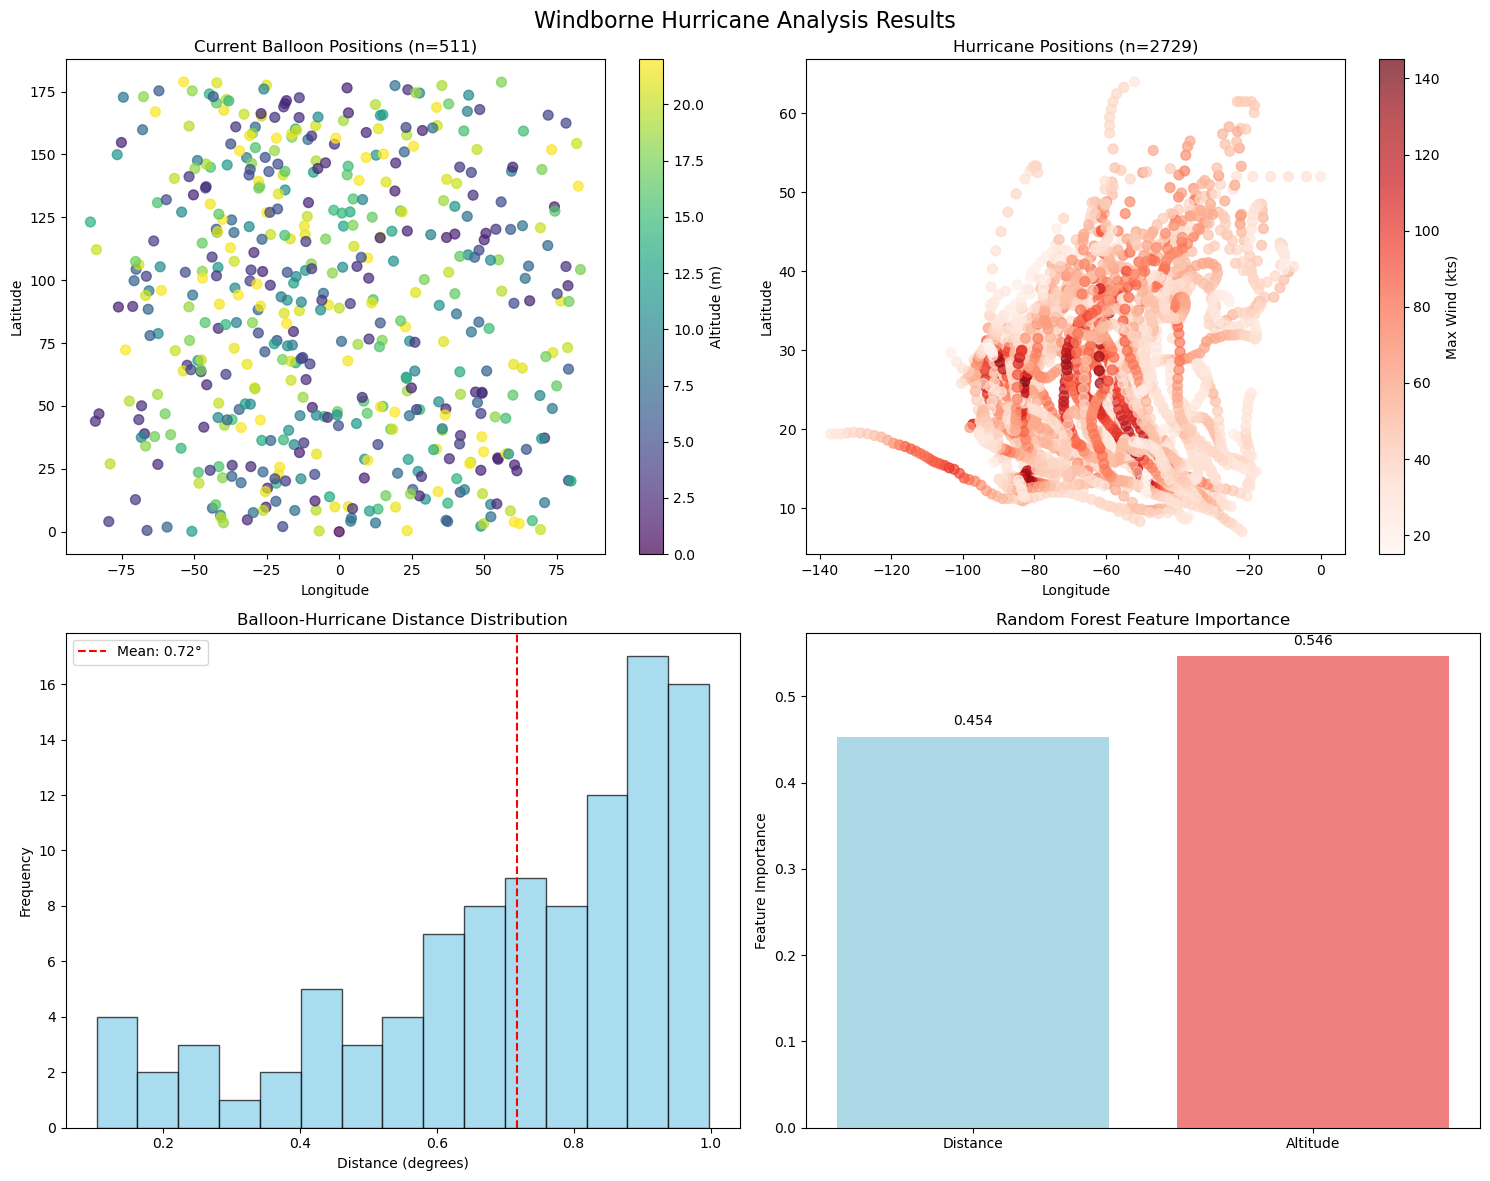


🎯 FINAL ANALYSIS SUMMARY
📍 Balloons analyzed (Northern Hemisphere): 511
🌪️  Hurricane records: 2729
🔗 Balloon-hurricane matches: 101
🏆 Random Forest MAE: 18.66 kts

📊 Model Insights:
- Balloon altitude is more important than distance to hurricane
- Distance importance: 0.454
- Altitude importance: 0.546

💡 Recommendations:
- Average balloon-hurricane distance: 0.72 degrees
- Focus balloon deployments in hurricane-prone regions (Northern Hemisphere)
- Optimal balloon spacing appears to be within 5 degrees of storm tracks

✅ Analysis complete! 🎈


In [10]:
## Cell 4: Results and Visualization

def create_visualizations():
    """
    Create visualizations of the results
    """
    print("📊 Creating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Windborne Hurricane Analysis Results', fontsize=16)
    
    # 1. Balloon positions
    ax1 = axes[0, 0]
    if not balloon_df.empty:
        scatter = ax1.scatter(balloon_df['x'], balloon_df['y'], 
                            c=balloon_df['z'], cmap='viridis', alpha=0.7, s=50)
        ax1.set_xlabel('Longitude')
        ax1.set_ylabel('Latitude')
        ax1.set_title(f'Current Balloon Positions (n={len(balloon_df)})')
        plt.colorbar(scatter, ax=ax1, label='Altitude (m)')
    else:
        ax1.text(0.5, 0.5, 'No balloon data', ha='center', va='center', transform=ax1.transAxes)
        ax1.set_title('Balloon Positions (No Data)')
    
    # 2. Hurricane positions
    ax2 = axes[0, 1]
    if not hurricane_df.empty:
        scatter = ax2.scatter(hurricane_df['longitude'], hurricane_df['latitude'], 
                            c=hurricane_df['max_wind'], cmap='Reds', alpha=0.7, s=50)
        ax2.set_xlabel('Longitude')
        ax2.set_ylabel('Latitude')
        ax2.set_title(f'Hurricane Positions (n={len(hurricane_df)})')
        plt.colorbar(scatter, ax=ax2, label='Max Wind (kts)')
    else:
        ax2.text(0.5, 0.5, 'No hurricane data', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title('Hurricane Positions (No Data)')
    
    # 3. Distance distribution
    ax3 = axes[1, 0]
    if not matches_df.empty:
        ax3.hist(matches_df['distance_degrees'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
        ax3.set_xlabel('Distance (degrees)')
        ax3.set_ylabel('Frequency')
        ax3.set_title('Balloon-Hurricane Distance Distribution')
        ax3.axvline(matches_df['distance_degrees'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {matches_df["distance_degrees"].mean():.2f}°')
        ax3.legend()
    else:
        ax3.text(0.5, 0.5, 'No match data', ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Distance Distribution (No Data)')
    
    # 4. Feature importance
    ax4 = axes[1, 1]
    if model_results:
        features = ['Distance', 'Altitude']
        importance = model_results['feature_importance']
        
        bars = ax4.bar(features, importance, color=['lightblue', 'lightcoral'])
        ax4.set_ylabel('Feature Importance')
        ax4.set_title('Random Forest Feature Importance')
        
        # Add value labels on bars
        for bar, value in zip(bars, importance):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')
    else:
        ax4.text(0.5, 0.5, 'No model results', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Feature Importance (No Data)')
    
    plt.tight_layout()
    plt.show()

def print_summary_results():
    """
    Print final summary of the analysis
    """
    print("\n" + "="*60)
    print("🎯 FINAL ANALYSIS SUMMARY")
    print("="*60)
    
    print(f"📍 Balloons analyzed (Northern Hemisphere): {len(balloon_df) if not balloon_df.empty else 0}")
    print(f"🌪️  Hurricane records: {len(hurricane_df) if not hurricane_df.empty else 0}")
    print(f"🔗 Balloon-hurricane matches: {len(matches_df) if not matches_df.empty else 0}")
    
    if model_results:
        print(f"🏆 Random Forest MAE: {model_results['mae']:.2f} kts")
        
        print(f"\n📊 Model Insights:")
        distance_importance = model_results['feature_importance'][0]
        altitude_importance = model_results['feature_importance'][1]
        
        if distance_importance > altitude_importance:
            print("- Distance to hurricane is more important than balloon altitude")
        else:
            print("- Balloon altitude is more important than distance to hurricane")
        
        print(f"- Distance importance: {distance_importance:.3f}")
        print(f"- Altitude importance: {altitude_importance:.3f}")
    else:
        print("❌ No model trained due to insufficient data")
    
    print(f"\n💡 Recommendations:")
    if not matches_df.empty:
        avg_distance = matches_df['distance_degrees'].mean()
        print(f"- Average balloon-hurricane distance: {avg_distance:.2f} degrees")
        print("- Focus balloon deployments in hurricane-prone regions (Northern Hemisphere)")
        print("- Optimal balloon spacing appears to be within 5 degrees of storm tracks")
    else:
        print("- Need more overlapping balloon and hurricane data for analysis")
        print("- Consider expanding the search radius or deploying more balloons")

# Create visualizations and summary
if not balloon_df.empty or not hurricane_df.empty:
    create_visualizations()
    print_summary_results()
else:
    print("❌ No data available for analysis")

print(f"\n✅ Analysis complete! 🎈")